In [1]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from src.utils.data import read_fasta
from src.data.datasets import ProteinDataset
import numpy as np
from src.utils.data import read_pickle
from sklearn.metrics import precision_recall_curve
from src.utils.evaluation import metrics_per_label_df
import seaborn as sns

/anaconda/envs/protein_functions/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = read_fasta('../data/swissprot/proteinfer_splits/random/train_GO.fasta')
val = read_fasta('../data/swissprot/proteinfer_splits/random/dev_GO.fasta')
test = read_fasta('../data/swissprot/proteinfer_splits/random/test_GO.fasta')

In [3]:
train = [(k[0],j," ".join(k[1:]),'train') for j,k in train]
test = [(k[0],j," ".join(k[1:]),'val') for j,k in test]
val = [(k[0],j," ".join(k[1:]),'test') for j,k in val]

df = train + val + test

In [4]:
df = pd.DataFrame(df,columns=['id','sequence','labels','split'])

In [5]:
num_sequences = len(df)
print('number of sequences:',num_sequences)

number of sequences: 522607


In [6]:
df.head()

,id,sequence,labels,split
0,P60545,MSKIIEYDETARRAIEAGVNTLADAVRVTLGPRGRHVVLAKAFGGP...,GO:0035639 GO:0032553 GO:0005524 GO:0017076 GO...,train
1,Q3KEX7,MKFSEQWLRGWVSPQVDRDALVARLSMAGLEVDSVTPAAGVFSGVV...,GO:0016070 GO:0035639 GO:0004812 GO:0032553 GO...,train
2,Q8D2U1,MKSVSIIDIIEKKIFKKKLVEINGWVRTKRNSKLGISFVDVYDGSC...,GO:0016070 GO:0004812 GO:0035639 GO:0032553 GO...,train
3,Q95KN1,MKPSLLVFTVYLLWLKDCHCAPTWKDKTDMHGNLKGFSEAGDIDVD...,GO:0044424 GO:0003674 GO:0044464 GO:0043226 GO...,train
4,Q98HL0,MNSLDLPGRPENTRIVVAMSGGVDSSVVAGLLKREGYDVVGVTLQL...,GO:0016070 GO:0035639 GO:0032553 GO:0005524 GO...,train


In [7]:
df['num_pos'] = df['labels'].str.split(' ').str.len()
df['num_pos'].describe()

In [9]:
labels = Counter()

vocab = set()
amino_freq = Counter()
for idx,row in df.iterrows():
    sequence = row['sequence']
    row_labels = row['labels']
    aa_list = list(sequence)
    if row_labels =='':
        print(row['id'],row['labels'])
    vocab.update(aa_list)
    amino_freq.update(aa_list)
    labels.update(row_labels.split(" "))

In [10]:
print('# GO Terms:',len(labels.keys()))

# GO Terms: 32102


In [11]:
print('GO Terms distribution')
go_term_distribution = pd.Series(labels.values(),index=labels.keys()).sort_values(ascending=False)
go_term_distribution.describe()

GO Terms distribution


count     32102.000000
mean        777.250545
std        9114.786603
min           1.000000
25%           4.000000
50%          17.000000
75%          84.000000
max      462356.000000
dtype: float64

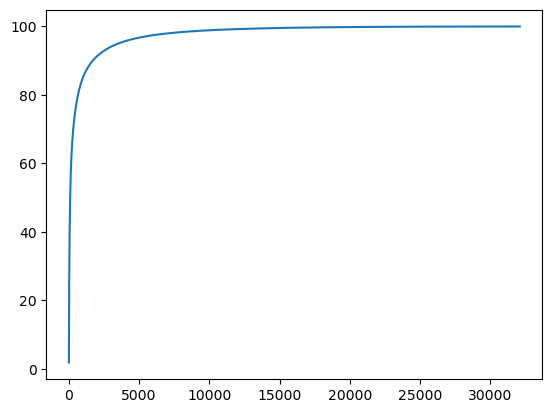

In [13]:
# Cumulative distribution of GO terms. Shows the number of GO terms that cover X% of the data
plt.plot(range(len(go_term_distribution)),(go_term_distribution*100/go_term_distribution.sum()).cumsum())

In [14]:
print('Sequence length distribution')

df['sequence'].apply(len).describe()

Sequence length distribution


count    522607.000000
mean        368.042215
std         334.721845
min           2.000000
25%         179.000000
50%         303.000000
75%         456.000000
max       35213.000000
Name: sequence, dtype: float64

# Explore Model Predictions

In [5]:
val_labels = pd.read_parquet("../results/labels_ProTCL.parquet")
val_probabilities = pd.read_parquet("../results/probabilities_ProTCL.parquet")
val_labels.index = [i[0] for i in val_labels.index]

In [8]:
#Define threshold to calculate threshold-dependent metrics otherwise only threshold-agnostic metrics are calculated
threshold = None
res=metrics_per_label_df(val_labels,val_probabilities,device='cuda',threshold=threshold)

  0%|          | 0/1183 [00:00<?, ?it/s]

100%|██████████| 1183/1183 [00:47<00:00, 25.05it/s]


In [80]:
res.head()

,AUPRC,Frequency,Relative Frequency,Precision,Recall,F1,Frequency Bin,Frequency Bin Percentage Of Data,mid,Cumulative Percentage
GO:0000018,1.000000,1.0,0.01,0.0,0.0,0.0,"(0.0, 2.0]",2.657155,1.0,NaN
GO:1990415,1.000000,1.0,0.01,0.0,0.0,0.0,"(0.0, 2.0]",2.657155,1.0,NaN
GO:0000785,0.333333,1.0,0.01,0.0,0.0,0.0,"(0.0, 2.0]",2.657155,1.0,NaN
GO:0000469,1.000000,1.0,0.01,0.0,0.0,0.0,"(0.0, 2.0]",2.657155,1.0,NaN
GO:0000049,1.000000,2.0,0.02,0.0,0.0,0.0,"(0.0, 2.0]",2.657155,1.0,NaN


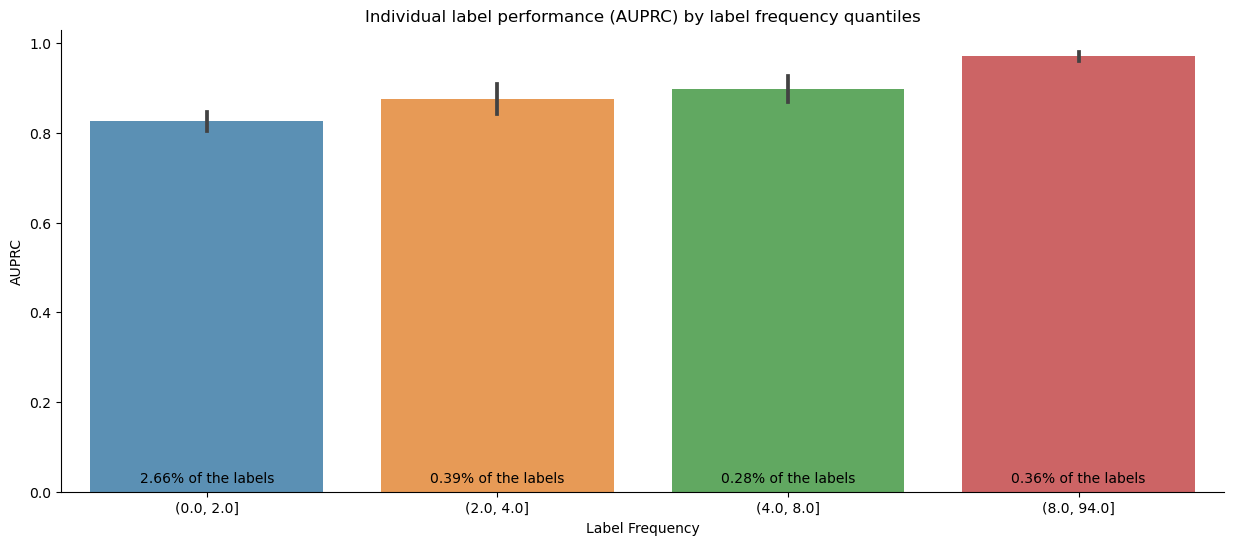

In [82]:
metric = 'AUPRC'
quantiles = 10 #May not find desired number and could be less.

fig, ax = plt.subplots(figsize=(15,6))
res['Frequency Bin'] = pd.qcut(res['Frequency'],q=quantiles,duplicates='drop',precision=0)

# Calculate the percentage of observations in each frequency bin
res['Frequency Bin Percentage Of Data'] = res.groupby('Frequency Bin')['Frequency'].transform('count') * 100/ len(res) 

# Annotate bars with the percentage of observations
for index, value in enumerate(res.groupby('Frequency Bin').first()['Frequency Bin Percentage Of Data']):
    ax.text(index, ax.get_ylim()[1]*0.01 + max(res[metric]) * 0.01, f"{value:.2f}% of the labels", ha='center')


sns.barplot(data = res,
            x='Frequency Bin',
            y=metric,
            alpha=0.8,
            errorbar=('ci', 95))
ax.set(title=f'Individual label performance ({metric}) by label frequency quantiles',
       xlabel='Label Frequency',
       ylabel=metric)
sns.despine()